In [1]:
from convLSTM_slip_detection_4 import ConvLSTMCell

import torch
from torch.autograd import Variable
import torch.nn.functional as f
from torch import nn

In [2]:
channels = 3
hidden_size = 32

model = ConvLSTMCell(channels, hidden_size)

model.load_state_dict(torch.load('./saved_model/convlstm_model_2layers_20190301.pth'))


if torch.cuda.is_available():
    # print 'sending model to GPU'
    model = model.cuda()

print repr(model)

ConvLSTMCell(
  (Gates_layer1): Conv2d(35, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Gates_layer2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear): Linear(in_features=28800, out_features=2, bias=True)
  (dropout): Dropout(p=0.3)
)


In [3]:
from convLSTM_dataset import *
from torch.utils.data import DataLoader

from torch.utils.data.dataset import random_split

In [4]:
    batch_size, channels, height, width = 32, 3, 30, 30
    hidden_size = 32  # 64           # hidden state size
    lr = 1e-5     # learning rate
    n_frames = 10           # sequence length
    max_epoch = 30  # number of epochs

    convlstm_dataset = convLSTM_Dataset(dataset_dir='../dataset3/resample_skipping/',
                                        n_class=2,
                                        transform=transforms.Compose([
                                            ToTensor()])
                                        )
    train_ratio = 0.9
    train_size = int(train_ratio*len(convlstm_dataset))
    test_size = len(convlstm_dataset) - train_size
    
    print test_size

    train_dataset, test_dataset = random_split(
        convlstm_dataset, [train_size, test_size])

#     train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
#                                   shuffle=True, num_workers=4)

    test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=True, num_workers=4)

320


In [5]:
    print('Create input and target Variables: x and y')
    x = Variable(torch.rand(n_frames, batch_size, channels, height, width))
    # y = Variable(torch.randn(T, b, d, h, w))
    y = Variable(torch.rand(batch_size))
    
    loss_fn = nn.CrossEntropyLoss()

Create input and target Variables: x and y


                test_loss = 0
                n_right = 0
                for test_step, test_sample_batched in enumerate(test_dataloader):
                    x = test_sample_batched['frames']
                    y = test_sample_batched['target']
                    x = torch.transpose(x, 0, 1)
                    # x = x.type(torch.FloatTensor)

                    if torch.cuda.is_available():
                        # print 'sending input and target to GPU'
                        x = x.type(torch.cuda.FloatTensor)
                        y = y.type(torch.cuda.FloatTensor)

                    state_test = None
                    out_test = None

                    for t in range(0, n_frames):
                        out_test, state_test = model(x[t], state_test)
                        # loss += loss_fn(state[0], y[t])

                    # out = out.long()
                    y = y.long()

                    # print out.size(), y.size()
                    test_loss += loss_fn(out_test, y).item() * batch_size

                    # Compute accuracy
                    _, argmax_test = torch.max(out_test, 1)
                    # print argmax_test
                    # print y
                    n_right += sum(y == argmax_test.squeeze()).item()

                # print n_right
                test_loss_reduced = test_loss/test_size
                test_accuracy = float(n_right)/test_size
                
                
                # print test_accuracy
                print ('[ TEST set]Loss: {:.6f}, Acc: {:.4f}'
                       .format( test_loss_reduced, test_accuracy))
                

In [6]:
    for test_step, test_sample_batched in enumerate(test_dataloader):
        # take only one data for visualization
        x = torch.unsqueeze(test_sample_batched['frames'][0], dim=0)
        y = test_sample_batched['target'][0]
        print x.shape
        x = torch.transpose(x, 0, 1)
        # x = x.type(torch.FloatTensor)
        print x.shape

        if torch.cuda.is_available():
            # print 'sending input and target to GPU'
            x = x.type(torch.cuda.FloatTensor)
            y = y.type(torch.cuda.FloatTensor)

        state_test = None
        out_test = None
        
        state_vis = []
        
        for t in range(0, n_frames):
            out_test, state_test = model(x[t], state_test)
            state_vis.append(state_test)

        _, argmax_test = torch.max(out_test, 1)

        print 'show a batch in test set...'
        print y
        print argmax_test.squeeze()
        break

torch.Size([1, 10, 3, 30, 30])
torch.Size([10, 1, 3, 30, 30])
show a batch in test set...
tensor(1., device='cuda:0')
tensor(1, device='cuda:0')


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0acbd4b990>> ignored


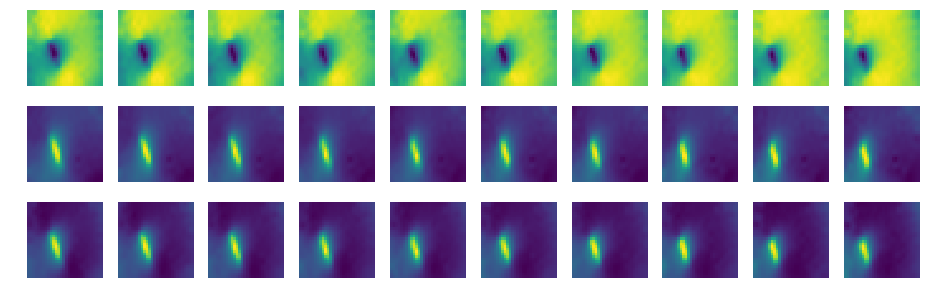

In [7]:
# print x[1]

## show frames
plt.figure(figsize=(16, 5))
for j in range(0, n_frames):
    pic = x[j].squeeze()[0]
    plt.subplot(3, n_frames, j+1)
    plt.imshow(pic)
    plt.axis('off')
    pic = x[j].squeeze()[1]
    plt.subplot(3, n_frames, n_frames + j+1)
    plt.imshow(pic)
    plt.axis('off')
    pic = x[j].squeeze()[2]
    plt.subplot(3, n_frames, 2*n_frames + j+1)
    plt.imshow(pic)
    plt.axis('off')

Visualize the intermedia hidden states and cell states
--

10
frame 9


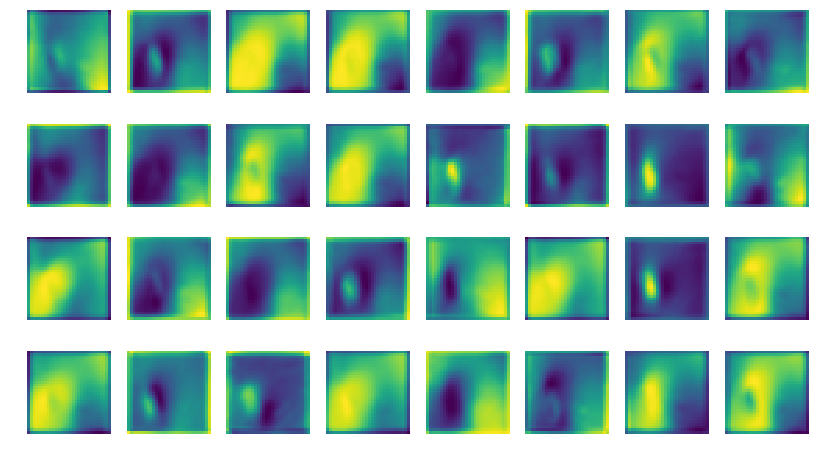

In [8]:
%matplotlib inline

print len(state_vis)
import matplotlib.pyplot as plt


for i in range(n_frames-1, n_frames):
    print 'frame {}'.format(i)
    plt.figure(figsize=(14,8))
    state1, state2 = state_vis[i]
    hidden_state, cell_state = state2

    hidden_state = hidden_state.cpu().detach().numpy()
#     cell_state = cell_state.cpu().detach().numpy()

    # print hidden_state[:,0,:,:].squeeze()
    for j in range(0, hidden_size):
        plt.subplot(4, hidden_size/4, j+1)
        plt.imshow(hidden_state[:,j,:,:].squeeze())
        plt.axis('off')
    
#     plt.pause(1)




## visualize last convolution output

conv2_np = conv2.cpu().detach().numpy().squeeze()

plt.figure(figsize=(10,10))
conv2_num = len(conv2_np)
for j in range(0, conv2_num):
    plt.subplot(4,conv2_num/4, j+1)
    plt.imshow(conv2_np[j,:,:])
    plt.axis('off')

## Visualize the FC layer weights that correponds to feature map


(2, 32, 30, 30)


<Figure size 1008x1008 with 0 Axes>

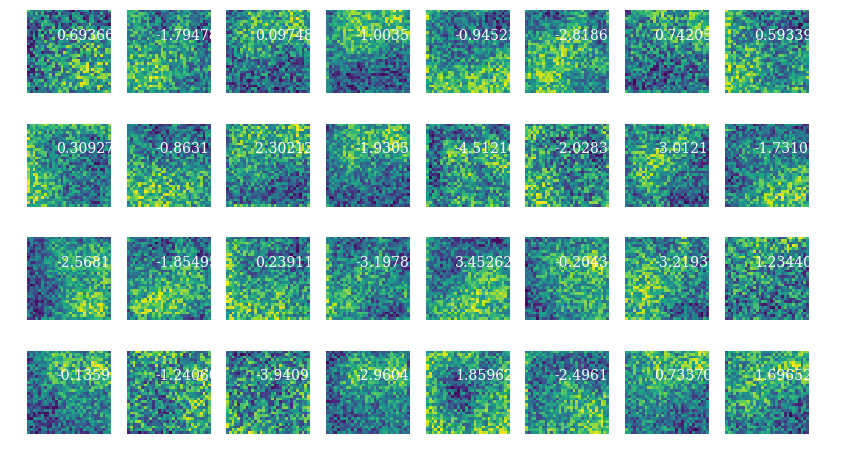

In [9]:
fc_weights = model.linear.weight.data
# fc_biases = model.linear.bias.data

# print fc_weights.shape

last_kernel_size = 32

fc_weights = fc_weights.view(2, last_kernel_size, 30, 30)

fc_weights = fc_weights.cpu().detach().numpy()
# fc_biases = fc_biases.cpu().detach().numpy()

print fc_weights.shape
# print fc_biases

# fc_weights_reshape = fc_weights.reshape((2, 64, 30, 30))
fc_weights_reshape = fc_weights

plt.figure(figsize=(14,14))

font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 14,
        }


# for j in range(0, hidden_size):
#         plt.subplot(np.sqrt(hidden_size), np.sqrt(hidden_size), j+1)
#         pic = fc_weights_reshape[0,j,:,:].squeeze()
#         pic_sum = pic.sum()
#         plt.text(10,10, str(pic_sum), fontdict=font)
#         plt.imshow(pic)
#         plt.axis('off')

plt.figure(figsize=(14,8))
for j in range(0, last_kernel_size):
        plt.subplot(4, last_kernel_size/4, j+1)
        pic = fc_weights_reshape[1,j,:,:].squeeze()
        pic_sum = pic.sum()
        plt.text(10,10, str(pic_sum), fontdict=font)
        plt.imshow(pic)
        plt.axis('off')

## multiply feature map with fc weights to show what feature contributes the most

[ 4 10 13 22 19]


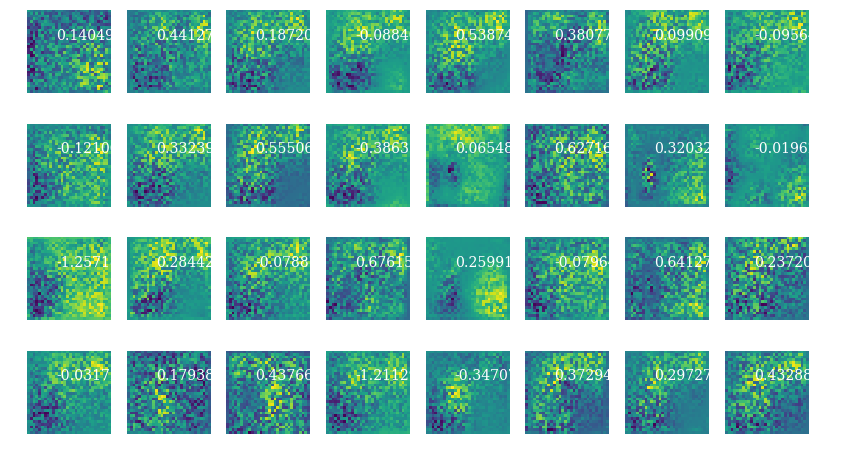

In [10]:
out_sum_array = []
plt.figure(figsize=(14,8))
for j in range(0, last_kernel_size):
        plt.subplot(4, last_kernel_size/4, j+1)
        feature_map = hidden_state[:,j,:,:].squeeze()
        weights_pic = fc_weights_reshape[1,j,:,:].squeeze()
        
        output = weights_pic*feature_map
        out_sum = output.sum()
        out_sum_array.append(out_sum)
        plt.text(10,10, str(out_sum), fontdict=font)
        plt.imshow(output)
        plt.axis('off')

        
ind_max = np.argsort(out_sum_array)[-5:]
print ind_max